# Predicting Student Academic Performance
Arshak Parsa

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import *
import plotly.express as px
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.neural_network import *
from sklearn.model_selection import *

import warnings
#warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

In [4]:
df = pd.read_csv("StudentsPerformance.csv")

df = df.rename(columns={"race/ethnicity" : "race", "test preparation course" : "tpc", 'parental level of education' : 'ParEdu'})

# test preparation course = tpc
nominal_var = ['gender', 'race', 'lunch', 'tpc']
ordinal_var = ['ParEdu']
numerical_var = ['reading score', 'writing score'] # except math score
len(nominal_var),len(ordinal_var),len(numerical_var)

df[nominal_var + ordinal_var] = df[nominal_var + ordinal_var].apply(lambda x: x.astype('category'))

# Task 1 (EDA)

In [5]:
print(df.head())
print(df.shape)
print(df.info())

   gender     race              ParEdu         lunch        tpc  math score  \
0  female  group B   bachelor's degree      standard       none          72   
1  female  group C        some college      standard  completed          69   
2  female  group B     master's degree      standard       none          90   
3    male  group A  associate's degree  free/reduced       none          47   
4    male  group C        some college      standard       none          76   

   reading score  writing score  
0             72             74  
1             90             88  
2             95             93  
3             57             44  
4             78             75  
(1000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   gender         1000 non-null   category
 1   race           1000 non-null   category
 2   ParEdu         1000 n

1000 samples and no missing data?! that's suspicious!


In [6]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


Reading and writing scores are higher than math score, ... Understandable!

In [7]:
print(f"Total duplicated rows: {df.duplicated().sum()}")

Total duplicated rows: 0


1000 samples and no duplicated rows?! Hmmm...

This dataset feels synthetic! It's too much clean! Anyways...

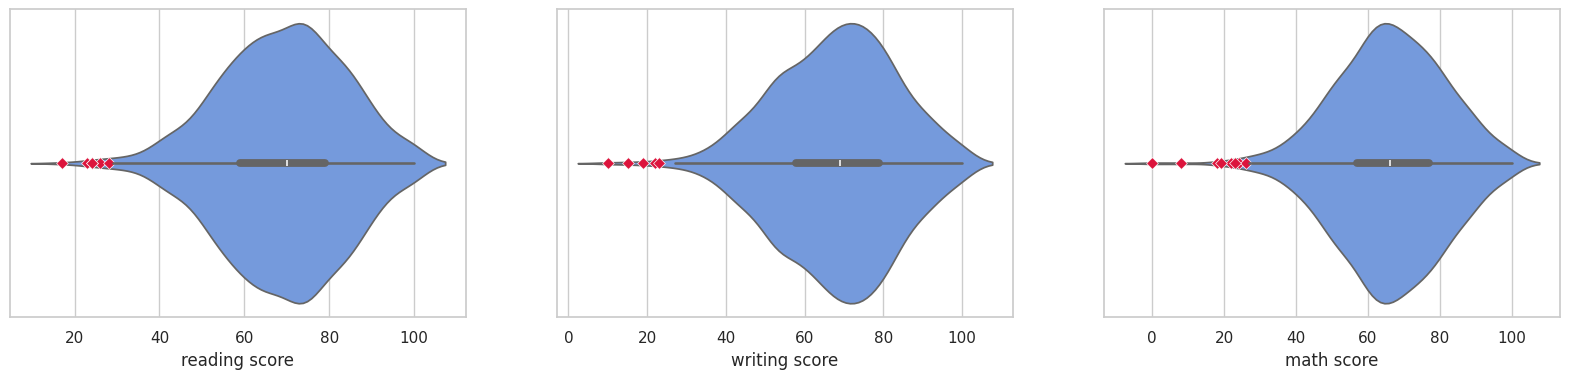

In [8]:
# Source - https://stackoverflow.com/questions/66913456/how-to-mix-the-outliers-from-boxplot-or-not-with-violin-plot
def custom_violinplot(d,ax,bw_adjust=1):
    q1, q3 = np.percentile(d, [25, 75])
    whisker_low = q1 - (q3 - q1) * 1.5
    whisker_high = q3 + (q3 - q1) * 1.5
    sns.violinplot(x=d, color='CornflowerBlue', ax=ax, bw_adjust=bw_adjust)
    outliers = d[(d > whisker_high) | (d < whisker_low)]
    if not outliers.empty:
        sns.scatterplot(x=outliers, y=0, marker='D', color='crimson', ax=ax)
    
    
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (20,4))
custom_violinplot(df['reading score'] ,axs[0])
custom_violinplot(df['writing score'] ,axs[1])
custom_violinplot(df['math score'] ,axs[2])

Nice and normal with a few outliers (probably backbenchers). 

Are you scared of outliers? Never remove them, a transformation might fix it.

No scaling is needed in my opinion since all three have the same range.

In [9]:
print(df.isnull().sum().sum())

0


No missing data as I have said before.

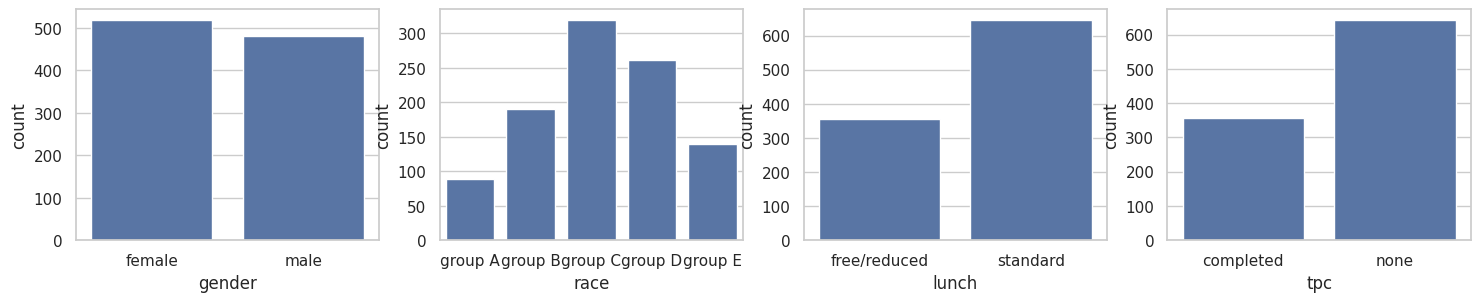

In [10]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize=(18, 3))
for i in range(4):
    sns.countplot(x=df[nominal_var[i]], ax = axs[i])

Race, lunch and TPC are not balanced, but .... Nice chart!

<Axes: xlabel='ParEdu', ylabel='count'>

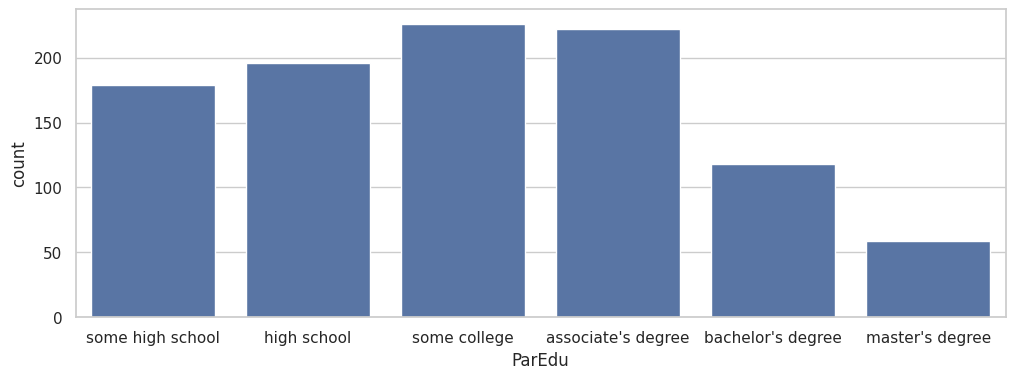

In [11]:
plt.figure(figsize=(12, 4))
order_edu = {
    'some high school' : 0,
    'high school' : 1,
    'some college' : 2,
    "associate's degree" : 3,
    "bachelor's degree" : 4,
    "master's degree" : 5
}
sns.countplot(x=df[ordinal_var[0]], order = order_edu)

No one likes to get a master's degree, ... Reasonable!

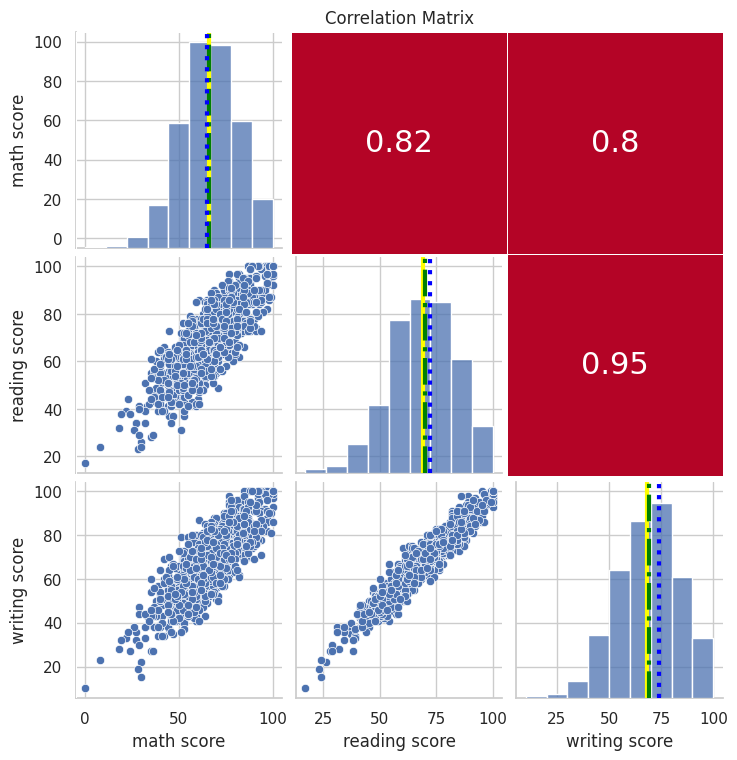

In [12]:
# Source - https://stackoverflow.com/a
# Posted by JohanC, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-11, License - CC BY-SA 4.0
# https://stackoverflow.com/questions/75289515/show-median-and-quantiles-on-seaborn-pairplot-python

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

def update_diag_func(data, label, color):
    plt.axvline(np.mean(data), color='yellow', linewidth=3.0)
    plt.axvline(np.median(data), color='green', linewidth=3.0, linestyle = '-.')
    plt.axvline(stats.mode(data).mode, color='blue', linewidth=3.0 , linestyle = ':')
    

def pairplot_heatmap(d1):
    e = sns.pairplot(d1, diag_kws = {'bins':9})

    e.map_diag(update_diag_func)
    e.map_upper(hide_current_axis)

    (xmin, _), (_, ymax) = e.axes[0, 0].get_position().get_points()
    (_, ymin), (xmax, _) = e.axes[-1, -1].get_position().get_points()

    ax = e.figure.add_axes([xmin, ymin, xmax - xmin, ymax - ymin], facecolor='none')

    corr1 = d1.corr()
    mask1 = np.tril(np.ones_like(corr1, dtype=bool))
    sns.heatmap(corr1, mask=mask1, cmap='coolwarm', vmax=.5, vmin=-.5,
                linewidths=.5, cbar=False, annot=True, annot_kws={'size': 22}, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.xaxis.tick_top()
    # ax.yaxis.tick_right()

    plt.title('Correlation Matrix')
    plt.show()

pairplot_heatmap(df.select_dtypes(['int64']))

You don't “correlate” with a nominal variable. Correlation only occurs among continuous variables. (I copied this from Reddit, LOL)

I shall say I **don't prefer** to plot and calculate correlation for nominal variables.

We have high correlation between all of them and that's understandable, if you have a high score in anything, there is a good chance that you have a high score in other things!

It's not cool to have highly correlated features since it causes multicollinearity but high correlation between features and the target variable (math score) is desired.

Let's create a preprocessor for ourself, shall we?

In [13]:
numerical_pipeline = Pipeline([
    # No missing data ,no Imputers
    ('pre-transformer', FunctionTransformer(func = (lambda x: x+0.001), feature_names_out = 'one-to-one')), 
    ('transformer', PowerTransformer(method='box-cox')), # For handling outliers, it's enough...
])

nominal_pipeline = Pipeline([
    # No missing data ,no Imputers
    ('encoder', OneHotEncoder())
])

ordinal_pipeline = Pipeline([
    # No missing data ,no Imputers
    ('encoder', OrdinalEncoder(categories = [list(order_edu.keys())]))
])

preprocessor = Pipeline([
    ('column_trans', ColumnTransformer([
    ('num', numerical_pipeline, numerical_var), 
    ('nom', nominal_pipeline, nominal_var),
    ('ord', ordinal_pipeline, ordinal_var),  ], verbose_feature_names_out=False)),
]) 


Let's test it

In [14]:
y = df['math score']

X = df.drop('math score', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.4,     
    random_state=5
)

print(f"Training set shape (X): {X_train.shape}")
print(f"Testing set shape (X): {X_test.shape}")

Training set shape (X): (600, 7)
Testing set shape (X): (400, 7)


In [15]:
X_train_preprocessed = pd.DataFrame(preprocessor.fit_transform(X_train), columns = preprocessor.get_feature_names_out(), index = X_train.index)
X_train_preprocessed

,reading score,writing score,gender_female,gender_male,race_group A,race_group B,race_group C,race_group D,race_group E,lunch_free/reduced,lunch_standard,tpc_completed,tpc_none,ParEdu
278,1.190109,0.784456,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
561,0.302191,0.358087,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
994,-0.468928,-0.456836,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
697,0.158815,0.080676,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0
908,0.374388,0.218682,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,-1.066151,-0.123655,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
118,-0.468928,-0.522334,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
701,-0.193534,0.218682,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
206,-0.536846,-0.456836,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,4.0


In [16]:
X_train

,gender,race,ParEdu,lunch,tpc,reading score,writing score
278,female,group C,some high school,free/reduced,none,86,80
561,female,group C,some college,standard,none,74,74
994,male,group A,high school,standard,none,63,62
697,female,group A,bachelor's degree,standard,none,72,70
908,female,group C,bachelor's degree,free/reduced,none,75,72
...,...,...,...,...,...,...,...
400,female,group C,some high school,standard,completed,54,67
118,female,group D,some high school,standard,none,63,61
701,female,group B,some high school,standard,none,67,72
206,male,group E,bachelor's degree,standard,none,62,62


In [17]:
preprocessor['column_trans']['num']['transformer'].lambdas_

array([1.34791526, 1.36296482])

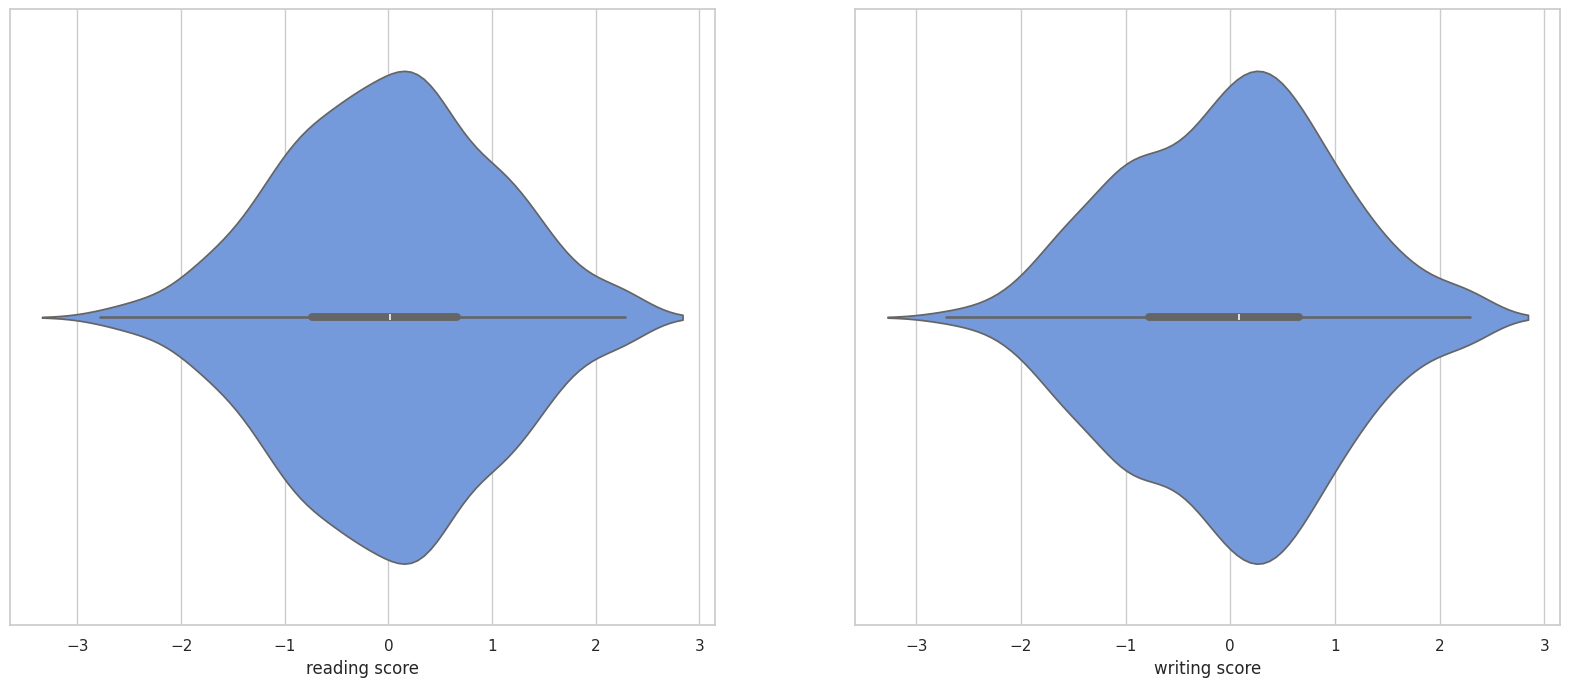

In [18]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (20,8))
custom_violinplot(X_train_preprocessed['reading score'] ,axs[0])
custom_violinplot(X_train_preprocessed['writing score'] ,axs[1])

![](pic/pb.gif "segment")

No more outliers! It's not magic, it is called TRANSFORMATION 🗿🗿🗿.

It's nice, isn't it? But look, it might make the interpretation of coefficients harder, so ... we might not use it for now, unless we get a very bad model.

Here is the formula of box cox

![](pic/box_cox.png)

I performed box cox because it is easier to interpret.

Lambdas are both positive which means box cox transformation is an increasing function.

I am pretty sure that we can interpret the coefficients just like how we interpret them in simple regression.


# Task 2 (All Features Allowed)

In [19]:
def basic_eval(y, yhat):
    print("\n--- Model Evaluation ---")

    print(f"  R-squared (R²): {r2_score(y, yhat):.4f}")

    print(f"  Mean Absolute Error (MAE): {mean_absolute_error(y, yhat):,.2f}")

    print(f"  Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y, yhat)):,.2f}")

In [20]:
model = Pipeline([
    ('prep', Pipeline([
    ('column_trans', ColumnTransformer([  
    ('nom', nominal_pipeline, nominal_var),
    ('ord', ordinal_pipeline, ordinal_var),  
    ], verbose_feature_names_out=False , remainder= 'passthrough')), ]) ), # don't forget to set remainder to 'passthrough'
    ('regressor', LinearRegression())
])

model.fit(X,y)

y_pred = pd.DataFrame(model.predict(X), columns = ["math score"])

basic_eval(y,y_pred)


--- Model Evaluation ---
  R-squared (R²): 0.8762
  Mean Absolute Error (MAE): 4.25
  Root Mean Squared Error (RMSE): 5.33


This model looks good enough!

In [21]:
print("\n--- Model Parameters ---")
print(f"Intercept (b): {model['regressor'].intercept_:.4f}")

coefficients = pd.DataFrame(
    data=model['regressor'].coef_.T, 
    index=model['prep'].get_feature_names_out(), 
    columns=['Coefficient']
)

coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
print("\nModel Coefficients (w):")
print(coefficients.sort_values(by='Abs_Coefficient', ascending=False))


--- Model Parameters ---
Intercept (b): 0.5822

Model Coefficients (w):
                    Coefficient  Abs_Coefficient
gender_male            6.626925         6.626925
gender_female         -6.626925         6.626925
race_group E           3.886853         3.886853
tpc_none               1.764953         1.764953
tpc_completed         -1.764953         1.764953
lunch_standard         1.612581         1.612581
lunch_free/reduced    -1.612581         1.612581
race_group A          -1.288033         1.288033
race_group D          -1.161469         1.161469
race_group C          -1.044164         1.044164
writing score          0.701900         0.701900
ParEdu                -0.417734         0.417734
race_group B          -0.393187         0.393187
reading score          0.262563         0.262563


Unfortunately sklearn does not provide a way for calculating p values and I don't have enough time for implementing it.

Starting with the coefficient of `writing score`, it's positive which means if you don't know how to write then how are you supposed to do math?! (It also had a high correlation with math when we plotted the heatmap)

The coefficients of `writing score` and `reading score` are small but note that their scale is way higher than other variables.

Next we got `gender`, well that's understandable since most mathematicians are, ..., you know, MALE! Just look at this picture I found on the internet

![](pic/mathematicians.jpg)

Most of them are men (I should have included Maryam Mirzakhani though, but anyways).

I don't know anything about group E in ethnicity but it looks like they are very good at math (probably chinese).

I like chinese people though, they are very smart!

The coefficient of `test preparation course` is positive for `none`, which is a little weird because `test preparation course` is supposed to improve their score, I don't know, ANYWAYS!

The most influential variable here, seems like to be `Gender`, but let's see the coefficients of the model with transformation. 

In [22]:
model_t = Pipeline([
    ('prep', preprocessor),
    ('regressor', LinearRegression())
])

model_t.fit(X_train,y_train)

print("\n--- Model Parameters ---")
print(f"Intercept (b): {model_t['regressor'].intercept_:.4f}")

coefficients = pd.DataFrame(
    data=model_t['regressor'].coef_.T, 
    index=model_t['prep'].get_feature_names_out(), 
    columns=['Coefficient']
)

coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
print("\nModel Coefficients (w):")
print(coefficients.sort_values(by='Abs_Coefficient', ascending=False))


--- Model Parameters ---
Intercept (b): 66.5118

Model Coefficients (w):
                    Coefficient  Abs_Coefficient
writing score         10.285073        10.285073
gender_male            6.733671         6.733671
gender_female         -6.733671         6.733671
race_group E           4.585821         4.585821
reading score          3.993154         3.993154
tpc_completed         -1.836265         1.836265
tpc_none               1.836265         1.836265
race_group A          -1.820109         1.820109
lunch_standard         1.672788         1.672788
lunch_free/reduced    -1.672788         1.672788
race_group D          -1.183039         1.183039
race_group C          -1.128211         1.128211
race_group B          -0.454461         0.454461
ParEdu                -0.432247         0.432247


You see, now the coefficient of writing is way higher because of their scales!
We shouldn't judge the coefficients with their magnitude!

In [23]:
import statsmodels.api as sm

# Fit the OLS model
model_stats = sm.OLS(y, sm.add_constant(pd.DataFrame(model['prep'].transform(X), columns = model['prep'].get_feature_names_out()))).fit()

# Print the summary of the model
print(model_stats.summary())

                            OLS Regression Results                            
Dep. Variable:             math score   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     700.2
Date:                Sun, 14 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:53:22   Log-Likelihood:                -3092.6
No. Observations:                1000   AIC:                             6207.
Df Residuals:                     989   BIC:                             6261.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2156      0

The coefficients are a little bit different but at least we have p values here.

So according to this , gender is a significant feature. Also, `lunch` is another significant feature which we didn't notice.

OK enough interpretation, let's move on.

Text(0, 0.5, 'residual')

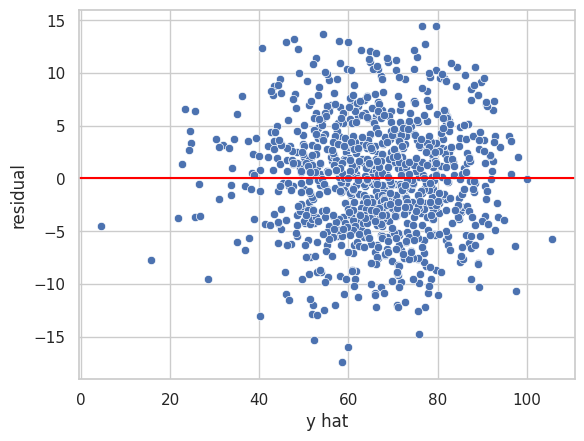

In [24]:
sns.scatterplot(x =y_pred['math score'], y = y - y_pred['math score'])
plt.axhline(0, color='red')
plt.xlabel('y hat')
plt.ylabel('residual')

<Axes: xlabel='math score', ylabel='Count'>

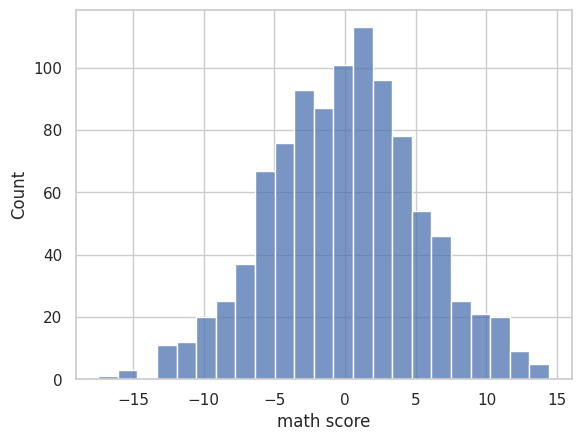

In [25]:
sns.histplot(y - y_pred['math score'])

No pattern, no increasing variance, residuals look normal, everything looks great here :)

# Task 3 (Course Grades Are Not Allowed)

The moment of great disaster!

In [26]:
model_task3 = Pipeline([
    ('prep', Pipeline([
        ('column_trans', ColumnTransformer([  
            ('nom', nominal_pipeline, nominal_var),
            ('ord', ordinal_pipeline, ordinal_var),  
        ], verbose_feature_names_out=False , remainder= 'drop')),
    ]) ),
    ('regressor', LinearRegression(fit_intercept=False))
])

model_task3.fit(X,y)

y_pred_task3 = pd.DataFrame(model_task3.predict(X), columns = ["math score"])

basic_eval(y,y_pred_task3)


--- Model Evaluation ---
  R-squared (R²): 0.2513
  Mean Absolute Error (MAE): 10.59
  Root Mean Squared Error (RMSE): 13.11


Just removing 2 variables ruined the performance.

In [27]:
print("\n--- Model Parameters ---")
print(f"Intercept (b): {model_task3['regressor'].intercept_:.4f}")

coefficients = pd.DataFrame(
    data=model_task3['regressor'].coef_.T, 
    index=model_task3['prep'].get_feature_names_out(), 
    columns=['Coefficient']
)

coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
print("\nModel Coefficients (w):")
print(coefficients.sort_values(by='Abs_Coefficient', ascending=False))


--- Model Parameters ---
Intercept (b): 0.0000

Model Coefficients (w):
                    Coefficient  Abs_Coefficient
lunch_standard        23.667169        23.667169
tpc_completed         21.027177        21.027177
gender_male           20.692028        20.692028
gender_female         15.742860        15.742860
tpc_none              15.407711        15.407711
race_group E          13.456927        13.456927
lunch_free/reduced    12.767719        12.767719
race_group D           8.696174         8.696174
race_group C           5.714389         5.714389
race_group B           5.228536         5.228536
race_group A           3.338863         3.338863
ParEdu                 1.666246         1.666246


Now `test preparation course_completed` is opposite.

OK, this model sucks, I don't see anything else, let's move on.

# Task 4 (Feature-Space Enrichment)

We can't do polynomial, since all numerical features we got are reading and writing scores.

We can do interactions but I don't have any hope for that.

Let's inspect the data a little more

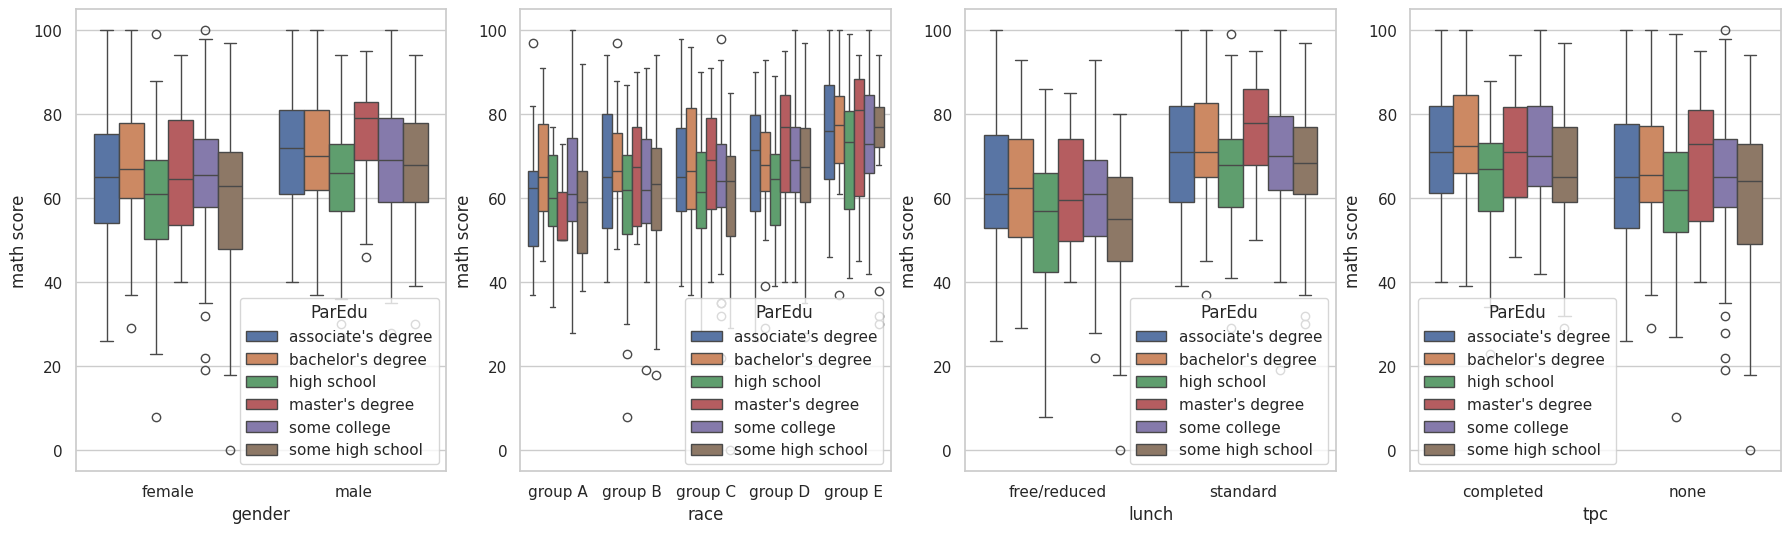

In [28]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize=(22, 6))
for i in range(4):
    sns.boxplot(df, x=nominal_var[i], y='math score', hue = "ParEdu" , ax = axs[i])

OK I can conclude that these features are very useless!

![](pic/anger-meme.jpg)

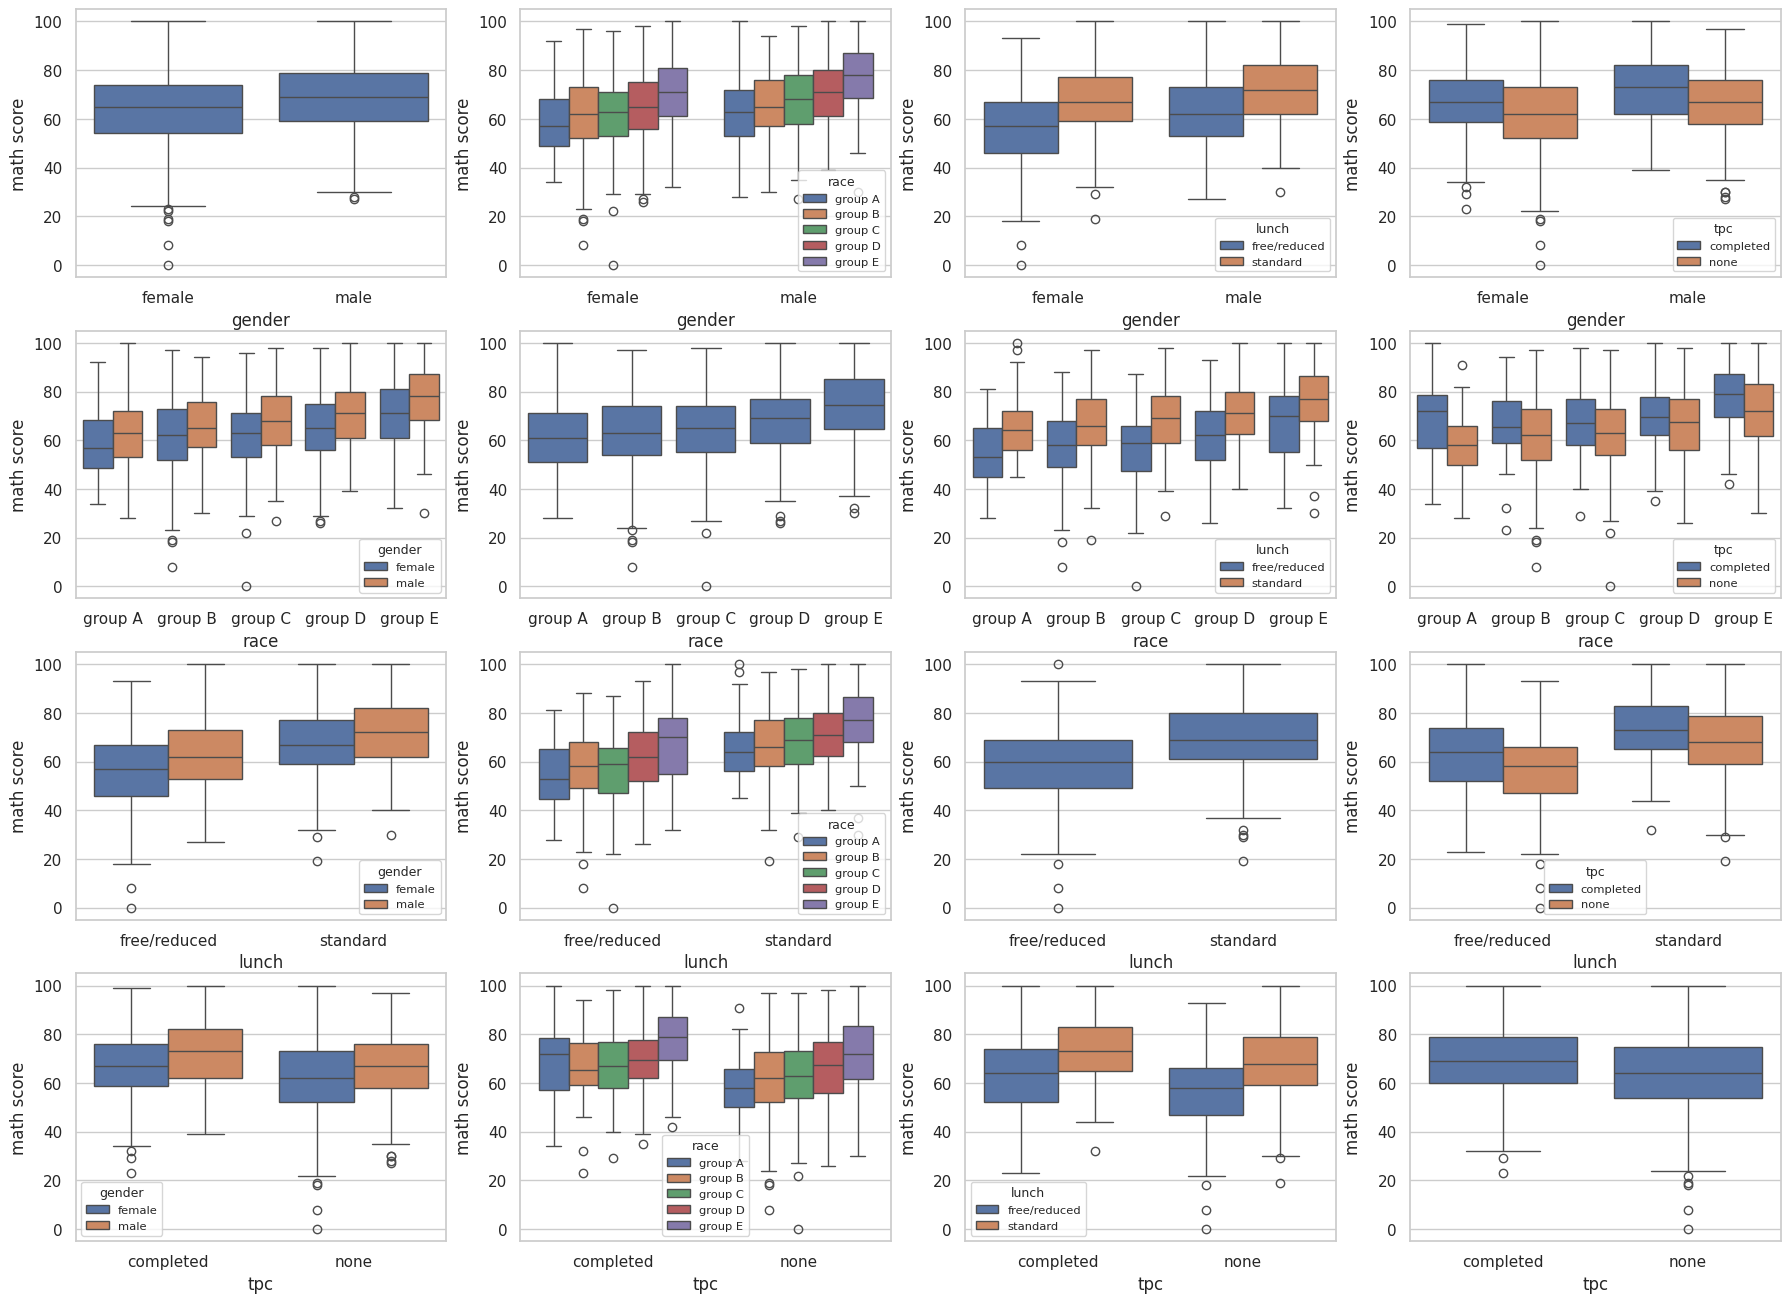

In [29]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize=(22, 16))
for i in range(4):
    for j in range(4):
        if i == j:
            sns.boxplot(df, x=nominal_var[i], y="math score", ax = axs[i][j])
        else:
            with sns.plotting_context("notebook", font_scale=.75):
                sns.boxplot(df, x=nominal_var[i], y="math score", hue = nominal_var[j], ax = axs[i][j])

Pretty nice, Huh? Well I'm a Data Scientist, that's what I do for a living! 

Looks like, `ethnicity` and `lunch` have some sort of weak relation. I don't know let's add that interaction.


In [30]:
rdf = df.drop(['writing score', 'reading score'], axis=1).sort_values(by='math score')
levels_of_score = [ 'Low',  "High"]
rdf['math score'] = pd.qcut(rdf['math score'], np.linspace(0,1,len(levels_of_score)+1), labels = levels_of_score)
px.parallel_categories(rdf)

These features are cursed!

Text(0, 0.5, 'mean math score')

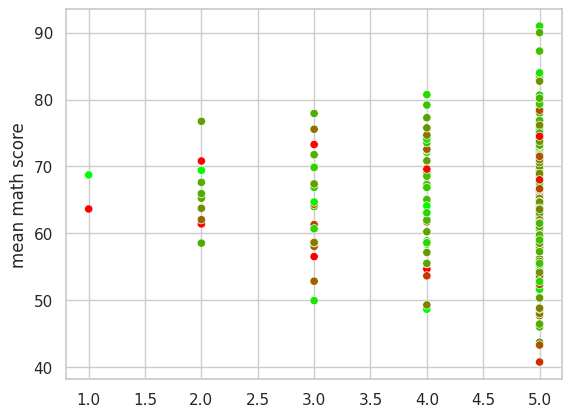

In [31]:
for i in range(1,len(nominal_var + ordinal_var)+1):
    gdf = df.groupby((nominal_var + ordinal_var)[:i], observed=True)['math score']
    sns.scatterplot(x = i, y =gdf.mean().reset_index()['math score'], hue = gdf.std().reset_index()['math score'], palette=sns.color_palette("blend:#00ff00,#ff0000", as_cmap=True), legend = False)
plt.ylabel('mean math score')

![](pic/bob-meme.gif)

Looks like there is some hope, let's not invent a new model for now!

In [32]:
model_dt = Pipeline([
    ('prep', Pipeline([
        ('column_trans', ColumnTransformer([  
            ('nom', nominal_pipeline, nominal_var),
            ('ord', ordinal_pipeline, ordinal_var),  
        ], verbose_feature_names_out=False , remainder= 'drop')),
    ]) ),
    ('regressor', DecisionTreeRegressor())
])

model_dt.fit(X,y)

y_pred_dt = pd.DataFrame(model_dt.predict(X), columns = ["math score"])

basic_eval(y,y_pred_dt)


--- Model Evaluation ---
  R-squared (R²): 0.3837
  Mean Absolute Error (MAE): 9.34
  Root Mean Squared Error (RMSE): 11.90


In [33]:
i = 5
print(model_dt.predict(X.iloc[[i]]),y[i])
X.iloc[[i]]

[62.09090909] 71


,gender,race,ParEdu,lunch,tpc,reading score,writing score
5,female,group B,associate's degree,standard,none,83,78


In [34]:
df[(df['gender'] == 'female') &
   (df['race'] == 'group B') &
   (df['ParEdu'] == "associate's degree") &
   (df['tpc'] == "none") &
   (df['lunch'] == "standard")   ]['math score'].mean()

np.float64(62.09090909090909)

No need to invent a new model, it already exists! It's called Decision Tree .... and it sucks!

Let's see ... 

In [35]:
prep1 = Pipeline([
    ('column_trans', ColumnTransformer([  
        ('nom', nominal_pipeline, nominal_var),
        ('ord', ordinal_pipeline, ordinal_var),  
    ], verbose_feature_names_out=False , remainder= 'drop')), ])

main_linreg, main_ridge, main_lasso, main_rf, main_dt, main_elastic, 
inter_linreg, inter_ridge, inter_lasso, inter_rf, inter_dt, inter_elastic, 
                  R2    RMSE     MAE  Prep.     Cls.
main_linreg    0.244  13.516  10.857   main   linreg
main_lasso     0.244  13.520  10.859   main    lasso
main_ridge     0.243  13.524  10.867   main    ridge
main_elastic   0.243  13.526  10.869   main  elastic
inter_ridge    0.217  13.753  10.954  inter    ridge
inter_linreg   0.215  13.764  10.976  inter   linreg
inter_lasso    0.212  13.796  10.985  inter    lasso
inter_elastic  0.212  13.798  10.981  inter  elastic
main_dt        0.196  13.920  11.253   main       dt
inter_dt       0.169  14.160  11.320  inter       dt
main_rf        0.074  14.918  12.025   main       rf
inter_rf       0.071  14.941  12.010  inter       rf


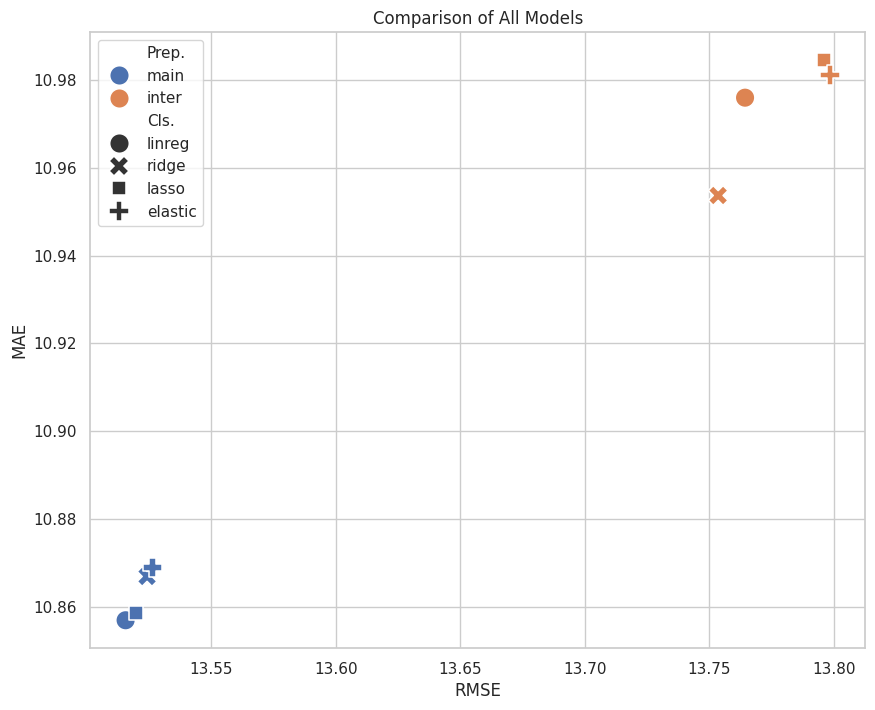

In [36]:
preprocessors = { 
    'main' : prep1,
    'inter' : Pipeline([
        ('column_trans', ColumnTransformer([  
            ('nom', 
             Pipeline([
                ("encoder", OrdinalEncoder()),
                ("inter", PolynomialFeatures(interaction_only= True, include_bias= True, degree = 3)),
             ]), nominal_var + ordinal_var),
        ], verbose_feature_names_out=False , remainder= 'drop')),])
    }
regressors = {  'linreg' : LinearRegression(),
                'ridge' : RidgeCV(), 
                'lasso' : LassoCV(max_iter=2000000),
                'rf' : RandomForestRegressor(),
                'dt' : DecisionTreeRegressor(max_depth = 4),
                'elastic' : ElasticNetCV()}


def RunAllModels(pres,regs):
    mp = {}# model performance
    for pre_name,pre in pres.items():
        for reg_name,reg in regs.items():
            model = Pipeline([
                ('preproc', pre),
                ('model', reg) 
            ])
            mp[pre_name+'_'+reg_name] = cross_validate(model, X, y, cv=ShuffleSplit(n_splits = 30, random_state = 7, test_size = 0.05), scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'], n_jobs = -1)
            print(pre_name+'_'+reg_name, end = ', ')
        print()
    return mp
            
mp = RunAllModels(preprocessors,regressors)

def remove_outliers(df,m1, m2, l = 11):
    return df[(df[m1]<l) | (df[m2]<l)]

def calc_scores(mp):
     res = {}
     for key in mp.keys():
          pre_name,reg_name = key.split('_')
          res[key] = {'R2' : mp[key]['test_r2'].mean(),
                         'RMSE' :((-mp[key]['test_neg_mean_squared_error'])**0.5).mean(),
                         'MAE' : (-mp[key]['test_neg_mean_absolute_error']).mean(),
                         'Prep.' :pre_name,
                         'Cls.' : reg_name}
     return res

res = calc_scores(mp)  

results_df = pd.DataFrame.from_dict(
     res, 
     orient='index', 
)
fig,ax = plt.subplots(figsize=(10,8))
sns.scatterplot(remove_outliers(results_df,'RMSE', 'MAE'),x="RMSE",y="MAE", hue = 'Prep.', style = 'Cls.', s =200)
ax.set(title="Comparison of All Models")
print(results_df.sort_values(by='R2', ascending=False).round(3))

Nope, I don't have any other tricks up my sleeve. SCREW THIS DATASET! :)

"Enriching this dataset" just makes everything worse! I don't know maybe I don't know what to do with!

Now, I'm thinking, ...  there is lower bound for $R^2$. Anyways let's not fall in this rabbit hole!

So, here is the conclusion:

Enriching the features makes these models better **if we use the same metrics** but if we run cross validation, the results are opposite and this is called **OVERFITTING**!

# Task 5 (Manual SGD Implementation)

OK, I have a cool idea...

![](pic/bob-meme.gif)

Let's implement SGD in symbolic way.

In [37]:
X_task3 = pd.DataFrame(prep1.fit_transform(X), columns = prep1.get_feature_names_out(), index = X.index)
X_task3

,gender_female,gender_male,race_group A,race_group B,race_group C,race_group D,race_group E,lunch_free/reduced,lunch_standard,tpc_completed,tpc_none,ParEdu
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,5.0
996,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
997,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
998,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0


Here is a SGD

In [38]:
from sympy import *

def MatS(symb,l):
    return Matrix([IndexedBase(symb)[i] for i in range(l)])

In [39]:

x = MatS('x',X_task3.shape[1])
Y = Matrix([symbols("y")])
w = MatS('w',X_task3.shape[1])

loss = ((w.T*x) - Y)**2
loss

Matrix([[(-y + w[0]*x[0] + w[10]*x[10] + w[11]*x[11] + w[1]*x[1] + w[2]*x[2] + w[3]*x[3] + w[4]*x[4] + w[5]*x[5] + w[6]*x[6] + w[7]*x[7] + w[8]*x[8] + w[9]*x[9])**2]])

In [40]:
for expr in [loss.diff(IndexedBase('w')[i]) for i in range(X_task3.shape[1])]:
    pprint(expr)

[2⋅(-y + w[0]⋅x[0] + w[10]⋅x[10] + w[11]⋅x[11] + w[1]⋅x[1] + w[2]⋅x[2] + w[3]⋅ ↪

↪ x[3] + w[4]⋅x[4] + w[5]⋅x[5] + w[6]⋅x[6] + w[7]⋅x[7] + w[8]⋅x[8] + w[9]⋅x[9] ↪

↪ )⋅x[0]]
[2⋅(-y + w[0]⋅x[0] + w[10]⋅x[10] + w[11]⋅x[11] + w[1]⋅x[1] + w[2]⋅x[2] + w[3]⋅ ↪

↪ x[3] + w[4]⋅x[4] + w[5]⋅x[5] + w[6]⋅x[6] + w[7]⋅x[7] + w[8]⋅x[8] + w[9]⋅x[9] ↪

↪ )⋅x[1]]
[2⋅(-y + w[0]⋅x[0] + w[10]⋅x[10] + w[11]⋅x[11] + w[1]⋅x[1] + w[2]⋅x[2] + w[3]⋅ ↪

↪ x[3] + w[4]⋅x[4] + w[5]⋅x[5] + w[6]⋅x[6] + w[7]⋅x[7] + w[8]⋅x[8] + w[9]⋅x[9] ↪

↪ )⋅x[2]]
[2⋅(-y + w[0]⋅x[0] + w[10]⋅x[10] + w[11]⋅x[11] + w[1]⋅x[1] + w[2]⋅x[2] + w[3]⋅ ↪

↪ x[3] + w[4]⋅x[4] + w[5]⋅x[5] + w[6]⋅x[6] + w[7]⋅x[7] + w[8]⋅x[8] + w[9]⋅x[9] ↪

↪ )⋅x[3]]
[2⋅(-y + w[0]⋅x[0] + w[10]⋅x[10] + w[11]⋅x[11] + w[1]⋅x[1] + w[2]⋅x[2] + w[3]⋅ ↪

↪ x[3] + w[4]⋅x[4] + w[5]⋅x[5] + w[6]⋅x[6] + w[7]⋅x[7] + w[8]⋅x[8] + w[9]⋅x[9] ↪

↪ )⋅x[4]]
[2⋅(-y + w[0]⋅x[0] + w[10]⋅x[10] + w[11]⋅x[11] + w[1]⋅x[1] + w[2]⋅x[2] + w[3]⋅ ↪

↪ x[3] + w[4]⋅x[4] + w[5]⋅x[5] + w[6]⋅x[6] + w[7

In [41]:
def subsV(f, symbs, vs):
    res = f
    for symb,v in zip(symbs,vs): 
        res = res.subs([(IndexedBase(symb)[i], j) for (i,j) in zip(range(len(v)),v)])
    return res

subsV(loss, 'w', [[1,2,3,4,12,15,-6]]) # example

Matrix([[(-y + w[10]*x[10] + w[11]*x[11] + w[7]*x[7] + w[8]*x[8] + w[9]*x[9] + x[0] + 2*x[1] + 3*x[2] + 4*x[3] + 12*x[4] + 15*x[5] - 6*x[6])**2]])

In [42]:
def SGD(X,y,loss,epoch,eta=0.0001,history = False, w = None):
    hist = {}
    if w == None:
        w = np.repeat(0, X.shape[1], axis=0)
    grad = lambdify([MatS('x',X.shape[1]),MatS('w',X.shape[1]),symbols("y")] ,[loss.diff(IndexedBase('w')[i])[0] for i in range(X.shape[1])])
    for t in range(epoch):
        for (xi , yi) in zip(X.itertuples(index = False), y):
            w = w - eta * np.array(grad(np.array(xi),w,yi))
        if history:
            hist[t] = w
    return (w,hist)

sgd_coef, sgd_hist = SGD(X_task3,y,loss,100, history = True)
sgd_coef

array([15.70451381, 20.71356791,  3.49999211,  5.40490237,  5.80039579,
        8.79296853, 12.91982292, 12.72734138, 23.69074034, 21.01418467,
       15.40389705,  1.76712754])

In [43]:
model_task3['regressor'].coef_

array([15.74286045, 20.69202767,  3.33886283,  5.22853568,  5.71438867,
        8.69617359, 13.45692734, 12.76771932, 23.6671688 , 21.02717705,
       15.40771107,  1.66624649])

In [44]:
y_pred_sgd =  np.matmul(sgd_coef.reshape(1,12),  X_task3.to_numpy().T).T
basic_eval(y,y_pred_sgd)


--- Model Evaluation ---
  R-squared (R²): 0.2508
  Mean Absolute Error (MAE): 10.60
  Root Mean Squared Error (RMSE): 13.12


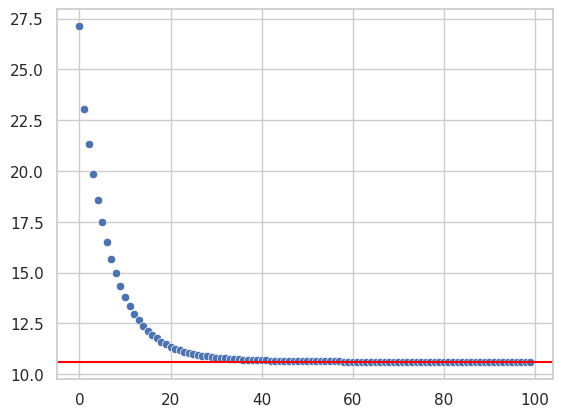

In [45]:
sns.scatterplot([mean_absolute_error(y,np.matmul(w.reshape(1,12),  X_task3.to_numpy().T).T) for _,w in sgd_hist.items()])
plt.axhline(mean_absolute_error(y,y_pred_task3), color = 'red')

# Task 6 (Manual SGD on Enriched Feature-Space)

In [46]:
prep4 = preprocessors['inter']
X_task4 = pd.DataFrame(prep4.fit_transform(X), columns = prep4.get_feature_names_out())
X_task4

,1,gender,race,lunch,tpc,ParEdu,gender race,gender lunch,gender tpc,gender ParEdu,...,gender race lunch,gender race tpc,gender race ParEdu,gender lunch tpc,gender lunch ParEdu,gender tpc ParEdu,race lunch tpc,race lunch ParEdu,race tpc ParEdu,lunch tpc ParEdu
0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,1.0,0.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
2,1.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0
3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,2.0,1.0,1.0,4.0,2.0,1.0,1.0,4.0,...,2.0,2.0,8.0,1.0,4.0,4.0,2.0,8.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,4.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0
996,1.0,1.0,2.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0,...,0.0,2.0,4.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0
997,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,1.0,0.0,3.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0


In [47]:
model_task4 = LinearRegression(fit_intercept = False).fit(X_task4,y)
print(model_task4.coef_)
y_pred_task4 = model_task4.predict(X_task4)
basic_eval(y,y_pred_task4)

[ 58.78304979   3.68143091   3.23133831   6.56658491 -10.037172
  -0.98654879  -0.5333904    7.29224868   3.54819669  -0.4791239
  -0.46389324  -0.36818233  -0.43771503   5.02066823   0.98173555
   0.89344474  -1.75083178   0.29086843   0.50276211  -6.48934463
  -0.99195039   0.10926279   0.78826792   0.38621702   0.11645911
  -1.34866462]

--- Model Evaluation ---
  R-squared (R²): 0.2374
  Mean Absolute Error (MAE): 10.60
  Root Mean Squared Error (RMSE): 13.23


In [48]:
x = MatS('x',X_task4.shape[1])
Y = Matrix([symbols("y")])
w = MatS('w',X_task4.shape[1])

loss = ((w.T*x) - Y)**2
loss

Matrix([[(-y + w[0]*x[0] + w[10]*x[10] + w[11]*x[11] + w[12]*x[12] + w[13]*x[13] + w[14]*x[14] + w[15]*x[15] + w[16]*x[16] + w[17]*x[17] + w[18]*x[18] + w[19]*x[19] + w[1]*x[1] + w[20]*x[20] + w[21]*x[21] + w[22]*x[22] + w[23]*x[23] + w[24]*x[24] + w[25]*x[25] + w[2]*x[2] + w[3]*x[3] + w[4]*x[4] + w[5]*x[5] + w[6]*x[6] + w[7]*x[7] + w[8]*x[8] + w[9]*x[9])**2]])

[31.15935066 10.468332   11.56590647 14.27216001  8.34034806  6.63871387
 -1.82853833  4.39441776  2.65310128 -2.01124167 -1.06573321 -4.91667633
 -2.94505087  4.0000407  -1.5056029  -4.30192827 -2.67258058 -0.80191149
  1.26596368 -0.08278934 -0.94968349 -0.23369149 -1.37197126  1.0690351
  1.89669386 -0.68616358]


Text(0, 0.5, 'R2')

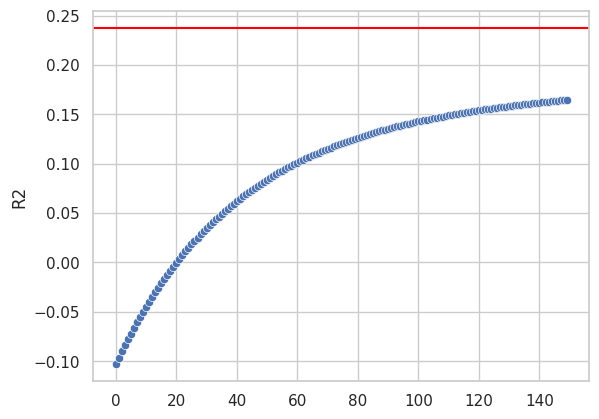

In [49]:
sgd5_coef, sgd5_hist = SGD(X_task4,y,loss,200,eta = 0.00004, history = True)
print(sgd5_coef)
sns.scatterplot([r2_score(y,np.matmul(w.reshape(1,len(w)),  X_task4.to_numpy().T).T) for _,w in sgd5_hist.items()][50:])
plt.axhline(r2_score(y,y_pred_task4), color = 'red')
plt.ylabel("R2")

Let's compare our implementation with sklearn's `SGDRegressor`

In [50]:
print(SGDRegressor(penalty=None, fit_intercept=False, shuffle = False,
             max_iter=500, learning_rate='constant', eta0 = 0.00004, tol = None, verbose = 0).fit(X_task4,y).coef_)

[32.96194686 10.87302412 11.24801827 14.78289006  8.20335525  6.4120516
 -2.16797012  4.40302828  2.32403377 -2.24156882 -1.55560147 -5.21053313
 -2.90986655  3.67598647 -1.77636299 -4.42318903 -2.48423598 -0.5599898
  1.27997404 -0.65309833 -0.85886954 -0.11447506 -0.98883583  1.17167752
  1.91066865 -0.623535  ]


Thanks god, they both suck! (There's a little difference in numbers though!)

Cool, so SGD is not good in this case!

In [51]:
basic_eval(y,np.matmul(sgd5_coef.reshape(1,len(w)), X_task4.to_numpy().T).T)


--- Model Evaluation ---
  R-squared (R²): 0.1648
  Mean Absolute Error (MAE): 11.10
  Root Mean Squared Error (RMSE): 13.85


SGD can't reach the max R2 which is 23% (with 200 epoches)

# Task 7 (Group-DRO Loss Regression)

Let's exclude the gender an see how good our model performs in each gender

In [52]:
X_task3

,gender_female,gender_male,race_group A,race_group B,race_group C,race_group D,race_group E,lunch_free/reduced,lunch_standard,tpc_completed,tpc_none,ParEdu
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,5.0
996,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
997,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
998,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0


In [53]:
X_DRO7 = X_task3.drop(['gender_female', 'gender_male'], axis = 1)

In [54]:
model_DRO3 = LinearRegression(fit_intercept = False).fit(X_DRO7,y)
print(model_DRO3.coef_)
y_pred_DRO3 = model_DRO3.predict(X_DRO7)
basic_eval(y,y_pred_DRO3)

[ 6.85863163  8.04192586  8.46383521 11.80072797 16.55908196 20.35682363
 31.367379   28.69055154 23.03365108  1.59689426]

--- Model Evaluation ---
  R-squared (R²): 0.2250
  Mean Absolute Error (MAE): 10.82
  Root Mean Squared Error (RMSE): 13.34


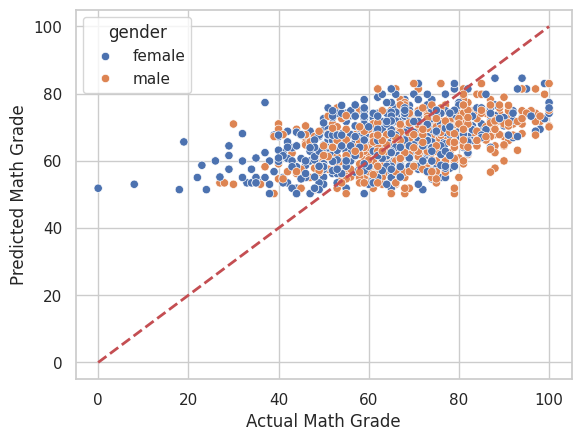

In [55]:
sns.scatterplot(x = y,y = y_pred_DRO3, hue = X['gender'])
plt.xlabel("Actual Math Grade")
plt.ylabel("Predicted Math Grade")
min_val = min(y.min(), y_pred_DRO3.min())
max_val = max(y.max(), y_pred_DRO3.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)


# Task 8 (Group-DRO Loss Regression on Enriched Feature-Space)